In [1]:
import pyarrow.parquet as pq
import pandas as pd

metadata_path = r"C:\Users\mayer\Работен плот\final forest detector\metadata.parquet"

# # table = pq.read_table(metadata_path)
# # df = table.to_pandas()
# print("Available columns in metadata:", df.columns.tolist())

#print(df.head())
#print(df.columns)

In [23]:
# INSTALL DEPENDENCIES (Colab only)
!pip install torch torchvision

# IMPORTS
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import rasterio 
# CUSTOM DATASET
import rasterio
import json

%pip install tqdm
from tqdm import tqdm
#loads the data from the BigEarthNet dataset, which is the strangly configurated one 
%pip install pandas 
import pandas as pd

%pip install pyarrow
import pyarrow

%pip install fastparquet
import fastparquet
metadata_path = r"C:\Users\mayer\Работен плот\final forest detector\metadata.parquet"

import pyarrow as pa
import pyarrow.parquet as pq

table = pq.read_table(metadata_path)
df = table.to_pandas()

class BigEarthNetVegetationDataset(Dataset):
    def __init__(self, root_dir, transform=None, metadata_file="metadata.parquet", filter_cloud=True):
        self.root_dir = root_dir
        self.samples = []
        self.transform = transform

        # Load metadata
        #metadata_path = os.path.join(root_dir, metadata_file)
        metadata_path = r"C:\Users\mayer\Работен плот\final forest detector\metadata.parquet"
        import pyarrow.parquet as pq
        table = pq.read_table(metadata_path)
        df = table.to_pandas()

        # Optional: remove patches with clouds/snow
        if filter_cloud:
            if "contains_cloud_or_shadow" in df.columns:
                df = df[df["contains_cloud_or_shadow"] == False]
            if "contains_seasonal_snow" in df.columns:
                df = df[df["contains_seasonal_snow"] == False]

        # Forest label set
        self.forest_labels = set(['Agro-forestry areas',
         'Broad-leaved forest', 
          'Coniferous forest',
           'Mixed forest',  'Transitional woodland, shrub'])
        # Add binary label column
        df["binary_label"] = df["labels"].apply(lambda labels: 1.0 if set(labels) & self.forest_labels else 0.0)

        # Select n- number of samples with forest and n-number without
        forest_df = df[df["binary_label"] == 1.0].sample(n=7500,random_state=42)
        non_forest_df = df[df["binary_label"] == 0.0].sample(n=7500, random_state=42)
        df = pd.concat([forest_df, non_forest_df]).reset_index(drop=True)


        for _, row in df.iterrows():
            patch_id = row["patch_id"]
            labels = set(row["labels"])

            # Map to binary: forest vs. no forest
            binary_label = 1.0 if labels & self.forest_labels else 0.0

            # Locate patch folder inside the root folder
            found = False
            for tile_folder in os.listdir(root_dir):
                tile_path = os.path.join(root_dir, tile_folder)
                patch_path = os.path.join(tile_path, patch_id)
                if os.path.isdir(patch_path):
                    found = True
                    break

            if not found:
                continue  # Skip if folder not found

            try:
                # Load Sentinel-2 bands
                blue = rasterio.open(os.path.join(patch_path, patch_id + "_B02.tif")).read(1).astype(np.float32) / 10000.0
                green = rasterio.open(os.path.join(patch_path, patch_id + "_B03.tif")).read(1).astype(np.float32) / 10000.0
                red = rasterio.open(os.path.join(patch_path, patch_id + "_B04.tif")).read(1).astype(np.float32) / 10000.0
                nir = rasterio.open(os.path.join(patch_path, patch_id + "_B08.tif")).read(1).astype(np.float32) / 10000.0

                # Compute NDVI
                ndvi = (nir - red) / (nir + red + 1e-5)

                # Stack channels: [4, H, W]
                stacked = np.stack([red, green, blue, ndvi], axis=0)

                self.samples.append((stacked, binary_label))

            except Exception as e:
                print(f"Skipping {patch_id} due to error: {e}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image, label = self.samples[idx]
        tensor = torch.tensor(image, dtype=torch.float32)
        tensor = F.interpolate(tensor.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False).squeeze(0)
        return tensor, torch.tensor(label, dtype=torch.float32)



class VegetationDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []

        for label, subfolder in enumerate(['NO_VEGETATION', 'VEGETATION']):
            folder = os.path.join(root_dir, subfolder)
            for file in os.listdir(folder):
                if file.endswith(('.npy', '.tif', '.tiff')):
                    self.samples.append((os.path.join(folder, file), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        if path.endswith('.npy'):
            array = np.load(path)  # shape: [H, W, 15]
            red = array[:, :, 3] / 10000.0
            green = array[:, :, 2] / 10000.0
            blue = array[:, :, 1] / 10000.0
            ndvi = array[:, :, 13]
        elif path.endswith(('.tif', '.tiff')):
            with rasterio.open(path) as src:
                try:
                    red = src.read(4).astype(np.float32) / 10000.0
                    green = src.read(3).astype(np.float32) / 10000.0
                    blue = src.read(2).astype(np.float32) / 10000.0
                    nir = src.read(8).astype(np.float32) / 10000.0
                except IndexError:
                    raise ValueError(f"{os.path.basename(path)} doesn't contain required bands 2, 3, 4, and 8")
                ndvi = (nir - red) / (nir + red + 1e-5)
        else:
            raise ValueError(f"Unsupported file format: {path}")

        # Stack and resize
        stacked = np.stack([red, green, blue, ndvi], axis=0)  # [4, H, W]
        tensor = torch.tensor(stacked, dtype=torch.float32)
        tensor = F.interpolate(tensor.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False).squeeze(0)

        return tensor, torch.tensor(label, dtype=torch.float32)

#  MODEL
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # assuming 64x64 patches
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 16, 16]
        x = x.view(x.size(0), -1)             # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # return logits (no sigmoid)

#  TRAINING SETUP
def train_model(dataset_path, num_epochs=10, batch_size=32):
    dataset = BigEarthNetVegetationDataset(dataset_path)
   # dataset = VegetationDataset(dataset_path)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    model = SimpleCNN(in_channels=4)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_history = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        for images, labels in progress:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress.set_postfix(loss=loss.item())
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {total_loss/len(train_loader):.4f}")
        loss_history.append(avg_loss)

    return model, loss_history



#  EVALUATION FUNCTION
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)               # logits
            probs = torch.sigmoid(outputs)        # convert logits to probabilities
            preds = torch.round(probs).squeeze()
            labels = labels.squeeze()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy

from PIL import Image

def predict(model, image_path):
    # Detect file type
    if image_path.endswith('.npy'):
        array = np.load(image_path)  # shape: [H, W, 15]
        red = array[:, :, 3] / 10000.0
        green = array[:, :, 2] / 10000.0
        blue = array[:, :, 1] / 10000.0
        ndvi = array[:, :, 13]

        # Stack to [4, H, W]
        stacked = np.stack([red, green, blue, ndvi], axis=0)
    elif image_path.endswith('.png') or image_path.endswith('.jpg'):
        img = Image.open(image_path).convert('RGB')
        img = img.resize((64, 64))  # Resize for consistency
        img = np.array(img).astype(np.float32) / 255.0

        red = img[:, :, 0]
        green = img[:, :, 1]
        blue = img[:, :, 2]
        ndvi = np.zeros_like(red)

        # Stack to [4, 64, 64]
        stacked = np.stack([red, green, blue, ndvi], axis=0)

    elif image_path.endswith('.tif') or image_path.endswith('.tiff'):
        import rasterio
        with rasterio.open(image_path) as src:
        # Read bands using Sentinel-2 standard band numbers:
        # Band 4 = red (index 4)
        # Band 3 = green (index 3)
        # Band 2 = blue (index 2)
        # Band 8 = NIR (index 8)
         red = src.read(4).astype(np.float32) / 10000.0
         green = src.read(3).astype(np.float32) / 10000.0
         blue = src.read(2).astype(np.float32) / 10000.0
         nir = src.read(8).astype(np.float32) / 10000.0

        # Compute NDVI
         ndvi = (nir - red) / (nir + red + 1e-5)

        # Stack to [4, H, W]
         stacked = np.stack([red, green, blue, ndvi], axis=0)
    else:
        raise ValueError("Unsupported file format. Use .npy or .png/.jpg")

    # Resize if needed (for .npy)
    if stacked.shape[1:] != (64, 64):
        tensor = torch.tensor(stacked, dtype=torch.float32).unsqueeze(0)  # [1, 4, H, W]
        tensor = F.interpolate(tensor, size=(64, 64), mode='bilinear', align_corners=False)
    else:
        tensor = torch.tensor(stacked, dtype=torch.float32).unsqueeze(0)

    # Predict
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        logit = model(tensor.to(device))
        prob = torch.sigmoid(logit).item()
        label = "VEGETATION" if prob > 0.5 else "NO_VEGETATION"
   
   # visualize = true 
    import matplotlib.pyplot as plt

    rgb_vis = np.stack([red, green, blue], axis=-1)
    rgb_vis = np.clip(rgb_vis, 0, 1)
    plt.figure(figsize=(4, 4))
    plt.imshow(rgb_vis)
    plt.title(f"Prediction: {label}", fontsize=14, color='green' if label == "VEGETATION" else 'red')
    plt.axis('off')
    plt.show()
  

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


Epoch 1/15: 100%|██████████| 375/375 [05:38<00:00,  1.11batch/s, loss=0.354]


Epoch 1/15, Avg Loss: 0.4679


Epoch 2/15: 100%|██████████| 375/375 [04:14<00:00,  1.47batch/s, loss=0.389]


Epoch 2/15, Avg Loss: 0.3863


Epoch 3/15: 100%|██████████| 375/375 [02:15<00:00,  2.76batch/s, loss=0.246]


Epoch 3/15, Avg Loss: 0.3594


Epoch 4/15: 100%|██████████| 375/375 [00:34<00:00, 10.78batch/s, loss=0.436]


Epoch 4/15, Avg Loss: 0.3403


Epoch 5/15: 100%|██████████| 375/375 [01:31<00:00,  4.11batch/s, loss=0.429] 


Epoch 5/15, Avg Loss: 0.3159


Epoch 6/15: 100%|██████████| 375/375 [00:42<00:00,  8.79batch/s, loss=0.429]


Epoch 6/15, Avg Loss: 0.2948


Epoch 7/15: 100%|██████████| 375/375 [00:43<00:00,  8.64batch/s, loss=0.257] 


Epoch 7/15, Avg Loss: 0.2782


Epoch 8/15: 100%|██████████| 375/375 [00:41<00:00,  8.96batch/s, loss=0.255] 


Epoch 8/15, Avg Loss: 0.2585


Epoch 9/15: 100%|██████████| 375/375 [01:11<00:00,  5.25batch/s, loss=0.192] 


Epoch 9/15, Avg Loss: 0.2236


Epoch 10/15: 100%|██████████| 375/375 [00:59<00:00,  6.31batch/s, loss=0.0891]


Epoch 10/15, Avg Loss: 0.1892


Epoch 11/15: 100%|██████████| 375/375 [00:56<00:00,  6.60batch/s, loss=0.261] 


Epoch 11/15, Avg Loss: 0.1578


Epoch 12/15: 100%|██████████| 375/375 [00:58<00:00,  6.46batch/s, loss=0.176] 


Epoch 12/15, Avg Loss: 0.1278


Epoch 13/15: 100%|██████████| 375/375 [00:57<00:00,  6.49batch/s, loss=0.0454] 


Epoch 13/15, Avg Loss: 0.0988


Epoch 14/15: 100%|██████████| 375/375 [00:56<00:00,  6.70batch/s, loss=0.201]  


Epoch 14/15, Avg Loss: 0.0739


Epoch 15/15: 100%|██████████| 375/375 [01:00<00:00,  6.17batch/s, loss=0.0206] 


Epoch 15/15, Avg Loss: 0.0588


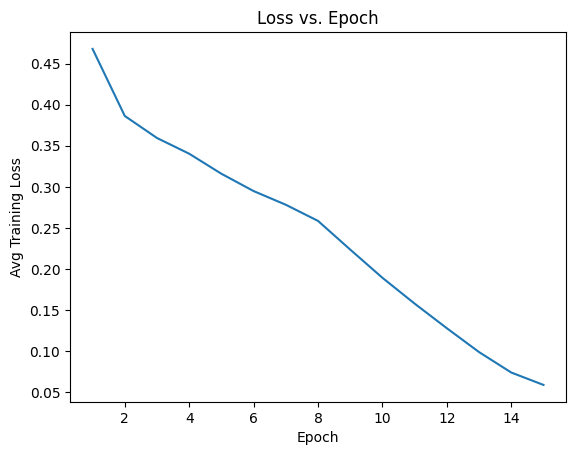

Total dataset size: 15000
Validation set size: 3000
Accuracy: 95.27%


0.9526666666666667

In [24]:
import zipfile
import os
import matplotlib.pyplot as plt

# Local path to the ZIP file
#zip_path = r"C:\Users\mayer\Работен плот\final forest detector\Big Earth Net Dataset\BigEarthNet-S2\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP"

# Folder where the data will be extracted
#extracted_path = r"C:\Users\mayer\Работен плот\final forest detector\Big Earth Net Dataset\BigEarthNet-S2\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP"

# Only extract if not already extracted
'''
if not os.path.exists(extracted_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

'''
from torch.utils.data import random_split
dataset_path=r"C:\Users\mayer\Работен плот\final forest detector\Big Earth Net Dataset\BigEarthNet-S2"
dataset = BigEarthNetVegetationDataset(dataset_path)
#dataset = VegetationDataset(dataset_path)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            preds = torch.round(torch.sigmoid(outputs)).squeeze()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Accuracy: {accuracy * 100:.2f}%")  # Shows 0-100%
    return accuracy
# Train the model using the extracted folder
model, loss_history = train_model(dataset_path=r"C:\Users\mayer\Работен плот\final forest detector\Big Earth Net Dataset\BigEarthNet-S2", num_epochs=15, batch_size=32)

plt.plot(range(1, len(loss_history)+1), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Avg Training Loss")
plt.title("Loss vs. Epoch")
plt.show()


from torch.utils.data import DataLoader

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
print(f"Total dataset size: {len(dataset)}")
print(f"Validation set size: {len(val_dataset)}")
# After model has finished training
evaluate_model(model, val_loader)

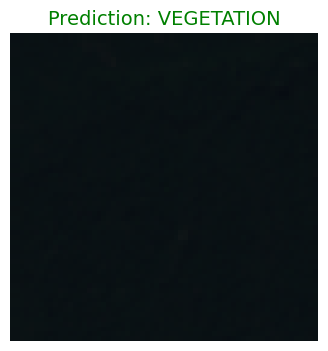

None


In [203]:

import zipfile
import os


testFile_path = r"C:\Users\mayer\Работен плот\final forest detector\photos from DIego previous project\Forest_2.tif" # Get the uploaded filename
result = predict(model, testFile_path)
print(result)

In [39]:
torch.save(model.state_dict(), "WeightsProbe.pth")

In [205]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
import csv
from PIL import Image

def _prepare_tensor_from_npy(path, input_size=(64,64), device=torch.device('cpu')):
    """
    Replicates your predict() preprocessing for .npy files:
      - expects array shape [H, W, 15]
      - red = arr[:,:,3] / 10000.0
      - green = arr[:,:,2] / 10000.0
      - blue = arr[:,:,1] / 10000.0
      - ndvi = arr[:,:,13]
      - stacks to shape (1, 4, H, W), resizes to input_size
    Returns a float tensor on the given device.
    """
    arr = np.load(path)  # user used arrays like this in predict()
    if arr.ndim != 3:
        raise ValueError(f"Expected 3D array for {path}, got shape {arr.shape}")
    # pick channels exactly like your predict()
    red = arr[:, :, 3].astype(np.float32) / 10000.0
    green = arr[:, :, 2].astype(np.float32) / 10000.0
    blue = arr[:, :, 1].astype(np.float32) / 10000.0
    ndvi = arr[:, :, 13].astype(np.float32)  # already NDVI
    stacked = np.stack([red, green, blue, ndvi], axis=0)  # shape (4, H, W)
    tensor = torch.from_numpy(stacked).unsqueeze(0).float()  # 1 x 4 x H x W
    # resize to model input if necessary (same as in predict() where you used image.resize)
    tensor = F.interpolate(tensor, size=input_size, mode='bilinear', align_corners=False)
    return tensor.to(device)

def _prepare_tensor_from_rgb_image(path, input_size=(64,64), device=torch.device('cpu')):
    """
    If you also want to process .png/.jpg files: open RGB, normalize to [0,1]
    and create a fake NDVI channel (zeros) so shape matches 4 channels.
    (Your predict() handles images differently; adjust if you used different steps.)
    """
    img = Image.open(path).convert('RGB')
    img = img.resize(input_size)
    arr = np.array(img).astype(np.float32) / 255.0
    # red, green, blue in same order used above
    red = arr[..., 0]
    green = arr[..., 1]
    blue = arr[..., 2]
    ndvi = np.zeros_like(red, dtype=np.float32)  # placeholder
    stacked = np.stack([red, green, blue, ndvi], axis=0)
    tensor = torch.from_numpy(stacked).unsqueeze(0).float()
    return tensor.to(device)

def classify_folder_using_predict_logic(model,
                                        folder_path,
                                        device=None,
                                        input_size=(64,64),
                                        threshold=0.5,
                                        save_csv_path=None,
                                        verbose=True):
    """
    Classify every .npy (and optionally .png/.jpg) in folder_path using the same preprocessing as predict().
    Returns a list of dicts: {'filename', 'prob', 'label'}.
    """
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model = model.to(device)
    model.eval()

    p = Path(folder_path)
    files = sorted([f for f in p.iterdir() if f.is_file() and f.suffix.lower() in ('.npy', '.png', '.jpg', '.jpeg')])

    results = []
    veg_count = 0
    nonveg_count = 0

    with torch.no_grad():
        for f in files:
            try:
                if f.suffix.lower() == '.npy':
                    tensor = _prepare_tensor_from_npy(str(f), input_size=input_size, device=device)
                else:
                    tensor = _prepare_tensor_from_rgb_image(str(f), input_size=input_size, device=device)

                out = model(tensor)    # model output (logit or logits)
                # normalize to single logit for "vegetation" class like in predict():
                if isinstance(out, torch.Tensor):
                    if out.dim() == 2 and out.size(1) == 2:
                        logit = out[:, 1]   # class-1 logit
                    else:
                        # out shape maybe [1,1] or [1]
                        logit = out.view(-1)[0:1]
                else:
                    # fallback
                    logit = torch.tensor([float(out)], device=device)

                prob = torch.sigmoid(logit).item()  # <--- IMPORTANT: apply sigmoid
                label = "VEGETATION" if prob > threshold else "NO_VEGETATION"

                results.append({'filename': str(f), 'prob': float(prob), 'label': label})
                if label == "VEGETATION":
                    veg_count += 1
                else:
                    nonveg_count += 1

                if verbose:
                    print(f"{f.name} -> prob={prob:.4f} -> {label}")

            except Exception as e:
                print(f"[ERROR] {f.name}: {e}")
                results.append({'filename': str(f), 'prob': None, 'label': 'ERROR', 'error': str(e)})

    if verbose:
        print(f"Processed {len(files)} files -> VEGETATION: {veg_count} ; NO_VEGETATION: {nonveg_count}")

    if save_csv_path:
        keys = sorted(set().union(*(r.keys() for r in results)))
        with open(save_csv_path, 'w', newline='') as csvf:
            writer = csv.DictWriter(csvf, fieldnames=keys)
            writer.writeheader()
            for r in results:
                writer.writerow(r)
        if verbose:
            print(f"Saved results to {save_csv_path}")

    return results


In [206]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN()  # or whatever your model class is
state_dict = torch.load(r"C:\Users\mayer\Работен плот\final forest detector\WeightsProbe.pth", map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()


SimpleCNN(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [213]:
# 1. Make sure you defined SimpleCNN and loaded your weights into model as we discussed
#    model = SimpleCNN(); model.load_state_dict(torch.load("WeightsProbe.pth", map_location=device))

# 2. Choose your folder path (where your .npy files are)
folder_path = r"C:\Users\mayer\Работен плот\final forest detector\sample_veg_detection_data\VEGETATION"   # <-- change this to your actual folder

# 3. Run classification
results = classify_folder_using_predict_logic(
    model,
    folder_path=folder_path,
    device=device,                # same device as you loaded the model on
    input_size=(64,64),           # must match training
    threshold=0.45,                # vegetation if prob >= 0.5
    #save_csv_path="predictions.csv",  # optional: writes a CSV file
    verbose=True
)

# 4. Inspect first few results
for r in results[:5]:
    print(r)


# Show first few results
for r in results[:5]:
    print(r)

# Count vegetation vs no vegetation
veg = sum(1 for r in results if r['label']=="VEGETATION")
nonveg = sum(1 for r in results if r['label']=="NO_VEGETATION")
print("VEGETATION:", veg, "NO_VEGETATION:", nonveg)



chile_tile_(1792, 7936).npy -> prob=0.6551 -> VEGETATION
chile_tile_(3072, 7936).npy -> prob=0.9795 -> VEGETATION
chile_tile_(3584, 7168).npy -> prob=0.9016 -> VEGETATION
chile_tile_(4864, 9984).npy -> prob=0.8044 -> VEGETATION
chile_tile_(5376, 7168).npy -> prob=0.8451 -> VEGETATION
chile_tile_(5888, 9728).npy -> prob=0.5538 -> VEGETATION
chile_tile_(6400, 6656).npy -> prob=0.9787 -> VEGETATION
chile_tile_(7168, 5120).npy -> prob=0.9659 -> VEGETATION
chile_tile_(7936, 8960).npy -> prob=0.9422 -> VEGETATION
chile_tile_(9984, 8704).npy -> prob=0.9670 -> VEGETATION
flipped_h_chile_tile_(1792, 7936).npy -> prob=0.8683 -> VEGETATION
flipped_h_chile_tile_(3072, 7936).npy -> prob=0.8497 -> VEGETATION
flipped_h_chile_tile_(3584, 7168).npy -> prob=0.8580 -> VEGETATION
flipped_h_chile_tile_(4864, 9984).npy -> prob=0.9077 -> VEGETATION
flipped_h_chile_tile_(5376, 7168).npy -> prob=0.8953 -> VEGETATION
flipped_h_chile_tile_(5888, 9728).npy -> prob=0.8421 -> VEGETATION
flipped_h_chile_tile_(6400, 